In [1]:
from eda_imports import *

In [2]:
pkl_files = sorted(glob.glob('../../gtf2csv-csvs/ensembl/*.pkl'))

In [3]:
len(pkl_files)

53

In [4]:
%%time
dfs_dd = {}
for f in tqdm(pkl_files):
    _df = pd.read_pickle(f)
    gtf_version = re.search(r'(GRCh|NCBI)\d\d\.\d\d', f).group()
    dfs_dd[gtf_version] = _df

100%|██████████| 53/53 [03:05<00:00,  3.50s/it]

CPU times: user 2min 4s, sys: 1min, total: 3min 4s
Wall time: 3min 5s


In [5]:
sorted_keys = sorted(dfs_dd.keys(), key=lambda s: float(re.search(r'\d\d\.\d\d', s).group()))

In [6]:
print(sorted_keys)

['NCBI36.43', 'NCBI36.44', 'NCBI36.46', 'NCBI36.47', 'NCBI36.48', 'NCBI36.49', 'NCBI36.50', 'NCBI36.51', 'NCBI36.52', 'NCBI36.53', 'NCBI36.54', 'GRCh37.55', 'GRCh37.56', 'GRCh37.57', 'GRCh37.58', 'GRCh37.59', 'GRCh37.60', 'GRCh37.61', 'GRCh37.62', 'GRCh37.63', 'GRCh37.64', 'GRCh37.65', 'GRCh37.66', 'GRCh37.67', 'GRCh37.68', 'GRCh37.69', 'GRCh37.70', 'GRCh37.71', 'GRCh37.72', 'GRCh37.73', 'GRCh37.74', 'GRCh37.75', 'GRCh37.82', 'GRCh37.85', 'GRCh37.87', 'GRCh38.76', 'GRCh38.77', 'GRCh38.78', 'GRCh38.79', 'GRCh38.80', 'GRCh38.81', 'GRCh38.82', 'GRCh38.83', 'GRCh38.84', 'GRCh38.85', 'GRCh38.86', 'GRCh38.87', 'GRCh38.88', 'GRCh38.89', 'GRCh38.90', 'GRCh38.91', 'GRCh38.92', 'GRCh38.93']


In [7]:
for k in tqdm(sorted_keys):
    _df = dfs_dd[k]
    if 'transcript_biotype' not in _df.columns:
        _df['transcript_biotype'] = _df['source']

#     if 'gencode' in f:
#         _df.rename(columns={
#             'gene_type': 'gene_biotype', 
#             'transcript_type': 'transcript_biotype', 
#         }, inplace=True)

100%|██████████| 53/53 [00:00<00:00, 145.64it/s]


In [8]:
%%time
trpt_biotypes_dfs = []
for k in tqdm(sorted_keys):
    df = dfs_dd[k]
    vc = df[['transcript_biotype', 'transcript_id']].drop_duplicates().transcript_biotype.value_counts().to_frame().T
    vc['gtf_version'] = k
    trpt_biotypes_dfs.append(vc)

100%|██████████| 53/53 [02:15<00:00,  2.56s/it]

CPU times: user 1min 21s, sys: 54.7 s, total: 2min 16s
Wall time: 2min 15s


In [9]:
df_vc = pd.concat(trpt_biotypes_dfs, sort=True)

In [10]:
ndf_vc = df_vc.set_index('gtf_version')

In [11]:
ndf_vc = ndf_vc[np.sort(ndf_vc.columns)]

In [12]:
ndf_vc.columns.values

array(['3prime_overlapping_ncRNA', '3prime_overlapping_ncrna', 'C_segment',
       'D_segment', 'IG_C_gene', 'IG_C_pseudogene', 'IG_D_gene',
       'IG_J_gene', 'IG_J_pseudogene', 'IG_V_gene', 'IG_V_pseudogene',
       'IG_pseudogene', 'J_segment', 'LRG_gene', 'Mt_rRNA', 'Mt_tRNA',
       'Mt_tRNA_pseudogene', 'TEC', 'TR_C_gene', 'TR_D_gene', 'TR_J_gene',
       'TR_J_pseudogene', 'TR_V_gene', 'TR_V_pseudogene', 'V_segment',
       'ambiguous_orf', 'antisense', 'antisense_RNA',
       'bidirectional_promoter_lncRNA', 'bidirectional_promoter_lncrna',
       'disrupted_domain', 'havana_pseudogene', 'known_ncrna', 'lincRNA',
       'macro_lncRNA', 'miRNA', 'miRNA_pseudogene', 'misc_RNA',
       'misc_RNA_pseudogene', 'ncrna_host', 'non_coding', 'non_stop_decay',
       'nonsense_mediated_decay', 'polymorphic_pseudogene',
       'processed_pseudogene', 'processed_transcript', 'protein_coding',
       'pseudogene', 'rRNA', 'rRNA_pseudogene', 'repeat',
       'retained_intron', 'retrotranspo

In [13]:
colors = []

for v in ndf_vc.index.values:
    vv = int(v[4:6])
    if vv == 36:
        c = 'blue'
    elif vv == 37:
        c = 'red'
    elif vv == 38:
        c = 'yellow'
    colors.append(c)

In [14]:
%%time
for trpt_type in tqdm(ndf_vc.columns):
    fig, ax = plt.subplots(1, 1, figsize=(16, 4))

    ndf_vc[trpt_type].plot.bar(ax=ax, color=colors, rot=45)

    for t in ax.xaxis.get_major_ticks():
        t.label.set_horizontalalignment('right')

    ax.yaxis.grid()
    ax.set_title(f'{trpt_type}_transcripts')
    ax.set_ylabel('#')
    
    plt.savefig(f'../../gtf2csv-csvs/figs/transcripts/{trpt_type}_transcripts.jpg', bbox_inches='tight')
    fig.clf()
    plt.close(fig)

100%|██████████| 73/73 [01:06<00:00,  1.10it/s]

CPU times: user 1min, sys: 5.07 s, total: 1min 5s
Wall time: 1min 6s


# Count protein coding genes

In [15]:
def count_genes(df, gene_biotype='protein_coding'):
    res = df.groupby(['gene_id']).apply(lambda g: gene_biotype in g.transcript_biotype.unique())
    return res[res].shape[0]

In [16]:
def count_genes_wrapper(gtf_version, df):
    n = count_genes(df)
    return gtf_version, n

In [17]:
%%time
res = []
for k, d in tqdm(dfs_dd.items()):
    d = d[['gene_id', 'transcript_biotype']].drop_duplicates()
    n = count_genes(d)
    res.append((k, n))

100%|██████████| 53/53 [08:15<00:00,  9.35s/it]

CPU times: user 7min 12s, sys: 1min 10s, total: 8min 23s
Wall time: 8min 15s


In [18]:
df_pc_genes = pd.DataFrame(res, columns=['gtf_version', 'num'])
df_pc_genes.set_index('gtf_version', inplace=True)
df_pc_genes = df_pc_genes.loc[sorted_keys]

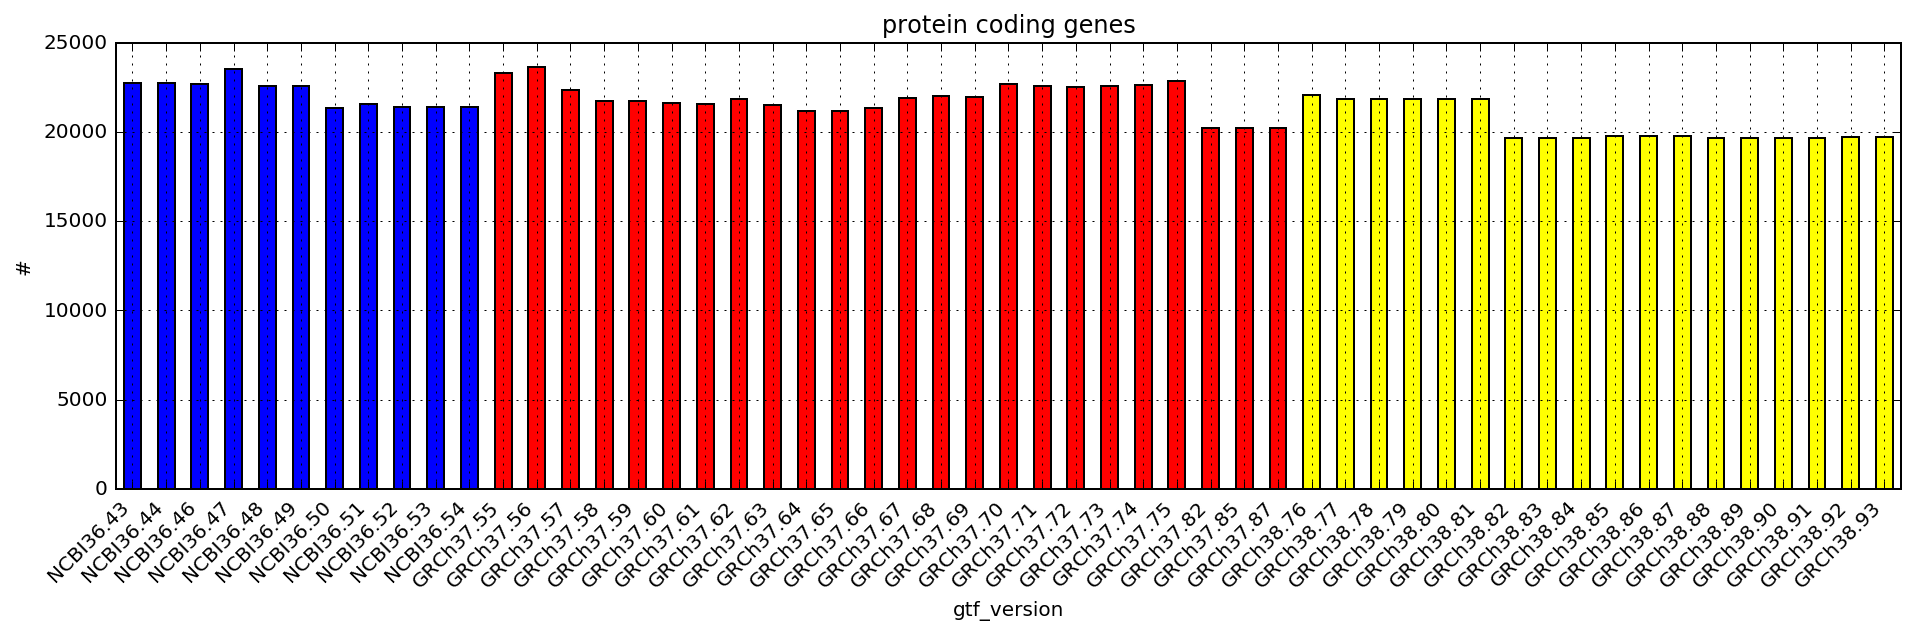

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

df_pc_genes.num.plot.bar(ax=ax, color=colors, rot=45)

for t in ax.xaxis.get_major_ticks():
    t.label.set_horizontalalignment('right')

ax.grid()
ax.set_title('protein coding genes')
ax.set_ylabel('#')
plt.savefig('../../gtf2csv-csvs/figs/num_protein_coding_genes.jpg', bbox_inches='tight')